# Monthly analysis: stations, bikes and quick dataframes


In [125]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Purpose and goals

<br>HSL has collect monthly data from 2016 to 2019 and every year has 7 different datasets. Big datasets provides a lot of information, but there might be additional value to review these sets separately.</br> 

<br>In this section the data is downscaled from yearly to monthly level. Doing this may help to notice smaller trends which would otherwise drown in to information overload.</br>   
<br>In this section the data of July 2019 is used as example data, but the cleaning is done by functions which able to reuse cleaning function also to other HSL dataframes. Beside cleaning function there are also quick dataframe functions which provide a quick tool for creating other dataframes without altering the original. 
Finally there is a quick rtation and route analysis of chosen station and route.</br>


## Limitations
This section route is defined as a straight trip from point A to point B. There are basically two types false data:

    1. There is a bug in HSL system which ends the data collection during the trip. These cases can be seen when
    distance is a lot shorter than averange distance of the route. Because we want to keep the data as clean as
    possible, we are going to the time and distance of these trips with average values of the route.
    2. Most of the rides taken with citybikes are straight transportations to point A to point B, but there is
    smalles subsegment of trips which are either joyrides or the user forgets to return the bike when the journey
    is finished. These can be seen when used time or distance is way over the average. Because it is impossible to
    track how these trips are done, these trips will be removed from data.


# Data in basic form


In [2]:
unprocessed_july=pd.read_csv("2019-07.csv")

In [72]:
unprocessed_july.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666362 entries, 0 to 666361
Data columns (total 8 columns):
Departure                 666362 non-null object
Return                    666362 non-null object
Departure station id      666362 non-null int64
Departure station name    666362 non-null object
Return station id         666357 non-null float64
Return station name       666357 non-null object
Covered distance (m)      666362 non-null float64
Duration (sec.)           666362 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 40.7+ MB


In data there are 5 entries where the Return Station and id are missing. These entries will be removed.

In [3]:
unprocessed_july.head()

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
0,2019-07-31T23:59:56,2019-08-01T10:31:34,32,Eläinmuseo,211.0,Haagan tori,5211.0,37893
1,2019-07-31T23:59:55,2019-08-01T00:05:15,32,Eläinmuseo,36.0,Apollonkatu,939.0,315
2,2019-07-31T23:59:48,2019-08-01T00:04:53,101,Munkkivuoren ostoskeskus,100.0,Teljäntie,994.0,301
3,2019-07-31T23:59:42,2019-08-01T00:06:55,109,Hertanmäenkatu,142.0,Koskelantie,1827.0,428
4,2019-07-31T23:59:40,2019-08-01T00:07:26,118,Fleminginkatu,111.0,Esterinportti,1833.0,461


Already in the first row (index 0) we can find a false value. The 5 km trip from Eläinmuseo to Haagan tori has taken over 10 and a half hours. This value will be removed when the dataframe is processed.

In [4]:
unprocessed_july.loc[156:158,]

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
156,2019-07-31T23:39:48,2019-07-31T23:51:29,41,Ympyrätalo,131.0,Elimäenkatu,2123.0,696
157,2019-07-31T23:39:46,2019-07-31T23:55:35,45,Brahen kenttä,25.0,Narinkka,2.0,945
158,2019-07-31T23:39:45,2019-07-31T23:47:10,44,Sörnäinen (M),133.0,Paavalinpuisto,1143.0,441


Another false value can be seen in row 157, the covered distance have been cutted short. This kind of error will be changed to average during dataframe processing.

# Cleaning dataframe


This sections examines data of a single month so it's usefull to clean data with functions so the code can be used again to clear other dataframes 

In [117]:
def meanDistance(dfMean, routeId):    #Function used to correct false values to mean         
    ret=dfMean["Covered distance (m)"][routeId] 
    return ret 


#Corrects and modifies dataframe
def router (df):
    updated=df[(df["Return station id"]!=df["Departure station id"])] #removes bikes which are returned to departure station
    updated["Covered distance (m)"]=np.where((updated["Covered distance (m)"]<0), 0, updated["Covered distance (m)"])#removes negative distance
    updated["Duration (sec.)"]=np.where((updated["Duration (sec.)"]<0), 0, updated["Duration (sec.)"])#removes negative time
    updated["Route"]=updated["Departure station name"]+"-"+updated["Return station name"]#creates Routes
    updated=updated[updated["Return station id"]>0]#removes stolen bikes
    updated["Return station id"]=updated["Return station id"].astype(int)#Changes type
    updated["Return station id"]=updated["Return station id"].astype(str)#Changes type
    updated["Departure station id"]=updated["Departure station id"].astype(str)#Changes type
    updated["Route id"]="f"+updated["Departure station id"]+"t"+updated["Return station id"]#Creates route id for later use
    ind = pd.DatetimeIndex(updated["Departure"]) #Adding time (Props for Nikolay)
    updated['Date'] = ind.date.astype('datetime64')   
    updated['Hour'] = ind.hour
    ret=updated[["Departure", "Return", "Route", "Route id", "Departure station id", "Return station id", "Covered distance (m)", "Duration (sec.)","Date", "Hour"]]# reshaping dataframe
    ave=ret.groupby(ret["Route id"]).mean().round(0)#Creates average dataframe which will replace false values
    #This searches bugs from travel distance and replaces them with mean of the trip
    ret["Covered distance (m)"]=np.where( (ret["Covered distance (m)"]*1.5<meanDistance(ave, ret["Route id"]).to_numpy() ) , meanDistance(ave, ret["Route id"]).to_numpy() , ret["Covered distance (m)"])
    ret=ret[ret["Covered distance (m)"]>100] #Removes faulty one trip routes which don't have averages    
    #We're studying trips which goes from point A to B, but there are some joyrides in dataframe which 
    #aren't straight trips. We will remove them from df by removing trips which are over 1.3 times the average 
    ret=ret[ret["Covered distance (m)"]<1.3*meanDistance(ave, ret["Route id"]).to_numpy()]
    ret=ret[ret["Duration (sec.)"]<5600]
    #There was still handfull of false values which could be found with average distance replaces, so
    #Those values are removed with next line
    ret=ret[ret["Covered distance (m)"]<10000]
    ret=ret[ret["Duration (sec.)"]>50]
    ret=ret[~((ret["Covered distance (m)"]<300) & (ret["Duration (sec.)"]>400))]
    ret=ret.sort_index(ascending=False)#Changes the earliest trip to first
    ret=ret.reset_index()#Resets index
    del ret["index"]#Remove old index
    
    return ret

#function which creates a quick cheatsheet of stations and station id's
def stations_and_id (df):
    ret=df
    ret=ret.set_index("Departure station id")
    ret=ret.sort_values(by=["Departure station id"])
    ret=ret["Departure station name"].drop_duplicates()
    return ret



In [123]:
station_id=stations_and_id(unprocessed_july)

In [124]:
station_id

Departure station id
1             Kaivopuisto
2         Laivasillankatu
3      Kapteeninpuistikko
4               Viiskulma
5               Sepänkatu
              ...        
767             Ruutikatu
769             Tiurintie
900            Orionintie
901        O'Bike Station
997     Workshop Helsinki
Name: Departure station name, Length: 346, dtype: object

In [33]:
july19=router(unprocessed_july)

/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In the new dataframe Departure, Return, Route, Route id, Departure station Id and Return station id are objects so they can be used in later functions. Date and Hour were added for later groupby-use. 

In [119]:
july19.head()

,Departure,Return,Route,Route id,Departure station id,Return station id,Covered distance (m),Duration (sec.),Date,Hour
0,2019-07-01T00:01:11,2019-07-01T00:32:38,Karhupuisto-Käpyläntie,f43t144,43,144,4561.0,1883,2019-07-01,0
1,2019-07-01T00:01:11,2019-07-01T00:20:26,Annankatu-Tilkantori,f49t105,49,105,5881.0,1155,2019-07-01,0
2,2019-07-01T00:01:34,2019-07-01T00:05:49,Petter Wetterin tie-Agnetankuja,f259t254,259,254,892.0,251,2019-07-01,0
3,2019-07-01T00:01:36,2019-07-01T00:10:07,Pernajantie-Koskelantie,f129t142,129,142,2091.0,505,2019-07-01,0
4,2019-07-01T00:01:47,2019-07-01T00:13:47,Korppaanmäentie-Thalianaukio,f106t221,106,221,2871.0,712,2019-07-01,0


Comparing the dataframe size shows that cleaning removed over 70000 trips which weren't fit for "from point A to point
B" policy.

In [35]:
print("Trips in orginal dataframe:",len(unprocessed_july))
print("Trips in processed dataframe:",len(july19))

Trips in orginal dataframe: 666362
Trips in processed dataframe: 587949


In [126]:
july19.describe()

,Covered distance (m),Duration (sec.),Hour
count,587949.000000,587949.000000,587949.000000
mean,2208.013216,696.811375,14.434796
std,1470.981267,463.471566,5.217902
min,162.000000,53.000000,0.000000
25%,1102.000000,356.000000,11.000000
50%,1799.000000,579.000000,15.000000
75%,2895.000000,932.000000,18.000000
max,9991.000000,5592.000000,23.000000


In [128]:
july19["Route"].value_counts().head()

Aalto-yliopisto (M), Korkeakouluaukio-Jämeräntaival    2518
Jämeräntaival-Aalto-yliopisto (M), Korkeakouluaukio    2468
Itämerentori-Salmisaarenranta                          1031
Itälahdenkatu-Gyldenintie                               948
Gyldenintie-Itälahdenkatu                               923
Name: Route, dtype: int64

# Functions for quick dataframe

Following functions can be used to create a new dataframe with wanted scope

In [129]:
#Use these functions to modify your cleared dataframe 
def day(df, date): #Use "yyyy-mm-dd"
    ret = df
    ret=ret[ret.Departure.str.contains(date)]
    return ret

def day_and_time(df, date, time): #You can use "hh" or "hh:mm" in time
    ret = df
    ret = ret[ (ret.Departure.str.contains(date)) & (ret.Departure.str.contains(("T"+time))) ]
    return ret

def daily_time(df, time): #Use "hh" or "hh:mm"
    ret = df
    ret = ret[ret.Departure.str.contains("T"+time)]
    return ret

def route(df, route): #Either route or route id
    ret=df
    ret=ret[(ret["Route"]==route) | (ret["Route id"]==route)]
    
    return ret

def select_station(df, station): #Station: id or name
    ret=df
    ret=ret[ (ret["Route"].str.contains(station))| (ret["Departure station id"]==station) | (ret["Return station id"]==station)]
    ret=ret.reset_index()
    del ret["index"]
    return ret

## Station analysis
Brahen kenttä is chosen as example station and select_station function is used to create a dataframe which includes all of the trips which have either started from or ended to Brahen kenttä's station.

In [130]:
July19_Brahe=select_station(july19, "Brahen kenttä")

In [131]:
print(len(July19_Brahe))
July19_Brahe.head()

7352


,Departure,Return,Route,Route id,Departure station id,Return station id,Covered distance (m),Duration (sec.),Date,Hour
0,2019-07-01T00:02:19,2019-07-01T00:19:17,Brahen kenttä-Vihdintie,f45t103,45,103,5170.0,1014,2019-07-01,0
1,2019-07-01T00:17:58,2019-07-01T00:37:06,Brahen kenttä-Liisanpuistikko,f45t16,45,16,2231.0,1144,2019-07-01,0
2,2019-07-01T00:18:15,2019-07-01T00:38:34,Brahen kenttä-Liisanpuistikko,f45t16,45,16,2168.0,1215,2019-07-01,0
3,2019-07-01T00:19:48,2019-07-01T00:31:35,Kalasatama (M)-Brahen kenttä,f126t45,126,45,1711.0,702,2019-07-01,0
4,2019-07-01T00:25:14,2019-07-01T00:30:46,Brahen kenttä-Pernajantie,f45t129,45,129,1262.0,331,2019-07-01,0


There can be added a new columns "Trips" and "Change" to display how the bike situation changes in station.

In [132]:
July19_Brahe["Trips"]=1
July19_Brahe["Change"]=np.where((July19_Brahe["Departure station id"]=="45"), -1, 1)

In [133]:
def group_station(df, time):#use Date or Hour
    ret=df.groupby(df[time]).mean()
    retS=df.groupby(df[time]).sum()
    ret["Change"]=retS["Change"]
    ret["Trips"]=retS["Trips"]
    ret=ret[["Trips", "Change", "Covered distance (m)", "Duration (sec.)"]]
    return ret

In [134]:
July19_Brahe_h=group_station(July19_Brahe, "Hour")


In [135]:
July19_Brahe_h

,Trips,Change,Covered distance (m),Duration (sec.)
Hour,,,,
0,221,-63,2171.176471,667.330317
1,121,-23,2186.603306,705.280992
2,99,-39,2041.575758,610.636364
3,52,0,2265.711538,683.730769
4,48,-6,2141.312500,700.104167
5,26,-16,2500.538462,698.307692
6,64,-30,2091.906250,582.484375
7,194,-34,2349.103093,630.876289
8,255,-63,2250.329412,624.909804


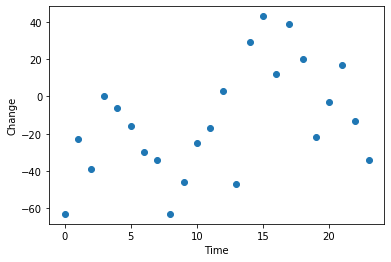

In [136]:
plt.scatter(July19_Brahe_h.index, July19_Brahe_h.Change)
plt.xlabel("Time")
plt.ylabel("Change")

plt.show()

In [137]:
July19_Brahe_h["Change"]=July19_Brahe_h["Change"]/31
July19_Brahe_h["Trips"]=July19_Brahe_h["Trips"]/31

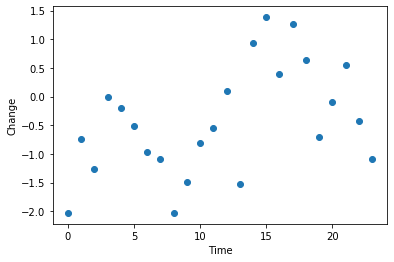

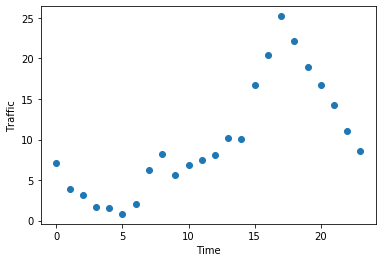

In [138]:
plt.scatter(July19_Brahe_h.index, July19_Brahe_h.Change)
plt.xlabel("Time")
plt.ylabel("Change")
plt.show()

plt.scatter(July19_Brahe_h.index, July19_Brahe_h.Trips)
plt.xlabel("Time")
plt.ylabel("Traffic")
plt.show()

Hourly scatter plot offer information about are there time of the day when station might more likelier to run out of bikes or the station might be full of bikes.

In Brahen Kenttä station, the stress level is quite low all the time. Even though there are some stress durin morning and afternoon. 

At monthly level, there can easily see daily trips and overall changes in bikes. 

In [45]:
July19_Brahe_m=group_station(July19_Brahe, "Date")

In [106]:
July19_Brahe_m

,Trips,Change,Covered distance (m),Duration (sec.)
Date,,,,
2019-07-01,274,-40,2222.215328,696.233577
2019-07-02,212,-14,2090.613208,614.169811
2019-07-03,254,12,2189.972441,675.933071
2019-07-04,291,-13,2122.639175,642.144330
2019-07-05,205,-7,2199.458537,687.736585
2019-07-06,119,-7,2173.588235,661.302521
2019-07-07,108,-6,2032.675926,614.685185
2019-07-08,178,-14,2094.646067,657.707865
2019-07-09,224,-10,2111.013393,639.138393


Examining daily level shows that Brahen kenttä is a station that is more likelier running out of bikes than station fill over capacity. Operators has to bring bikes from other stations to make sure they don't run out.

In [47]:
July19_Brahe["Route"].value_counts()

Sörnäinen (M)-Brahen kenttä       337
Brahen kenttä-Sörnäinen (M)       308
Brahen kenttä-Olympiastadion      170
Brahen kenttä-Ooppera             167
Ooppera-Brahen kenttä             135
                                 ... 
Brahen kenttä-Kylävoudintie         1
Brahen kenttä-Pohjolankatu          1
Brahen kenttä-Eränkävijäntori       1
Brahen kenttä-Länsisatamankatu      1
Brahen kenttä-Oulunkylän asema      1
Name: Route, Length: 370, dtype: int64

Value_counts show that the two most used route were both from Sörnäinen's subway station and to Sörnäinen's subway station.

# Route analysis

Since Sörnäinen was the most used station paired to Brahen kenttä, it is intresting to continue analysing this route.

In [48]:
most_used=route(july19, "Sörnäinen (M)-Brahen kenttä")

In [116]:
print(len(most_used))
most_used.head()

337


,Departure,Return,Route,Route id,Departure station id,Return station id,Covered distance (m),Duration (sec.),Date,Hour,Trips,Change
11409,2019-07-01T16:07:43,2019-07-01T16:12:05,Sörnäinen (M)-Brahen kenttä,f44t45,44,45,575.0,257,2019-07-01,16,1,-1
18836,2019-07-01T19:39:29,2019-07-01T19:43:14,Sörnäinen (M)-Brahen kenttä,f44t45,44,45,592.0,220,2019-07-01,19,1,-1
19435,2019-07-01T20:03:33,2019-07-01T20:07:23,Sörnäinen (M)-Brahen kenttä,f44t45,44,45,589.0,228,2019-07-01,20,1,-1
20675,2019-07-01T20:58:06,2019-07-01T21:01:11,Sörnäinen (M)-Brahen kenttä,f44t45,44,45,592.0,183,2019-07-01,20,1,-1
21166,2019-07-01T21:26:28,2019-07-01T21:29:35,Sörnäinen (M)-Brahen kenttä,f44t45,44,45,569.0,182,2019-07-01,21,1,-1


In [68]:
most_used.describe()

,Covered distance (m),Duration (sec.),Hour,Trips,Change
count,337.000000,337.000000,337.000000,337.0,337.0
mean,597.014837,232.379822,15.744807,1.0,-1.0
std,37.557215,157.235354,5.593910,0.0,0.0
min,559.000000,126.000000,0.000000,1.0,-1.0
25%,579.000000,175.000000,13.000000,1.0,-1.0
50%,589.000000,204.000000,17.000000,1.0,-1.0
75%,602.000000,252.000000,20.000000,1.0,-1.0
max,898.000000,2584.000000,23.000000,1.0,-1.0


In [69]:
most_mirror=route(july19, "Brahen kenttä-Sörnäinen (M)")

In [52]:
most_used["Trips"]=1
most_used["Change"]=np.where((most_used["Departure station id"]=="44"), -1, 1)
most_mirror["Trips"]=1
most_mirror["Change"]=np.where((most_mirror["Departure station id"]=="44"), -1, 1)

/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [53]:
most_h=group_station(most_used, "Hour")
del most_h["Change"]
mostM_h=group_station(most_mirror, "Hour")
del mostM_h["Change"]

In [54]:
most_h #Sörnäinen-Brahen kenttä 

,Trips,Covered distance (m),Duration (sec.)
Hour,,,
0,12,596.833333,186.916667
1,3,670.000000,497.666667
2,3,589.333333,166.000000
3,1,588.000000,207.000000
6,4,594.750000,222.250000
7,6,599.333333,266.833333
8,11,592.181818,198.363636
9,5,573.400000,221.200000
10,13,620.307692,230.538462


In [55]:
mostM_h

,Trips,Covered distance (m),Duration (sec.)
Hour,,,
0,7,611.857143,239.142857
1,2,571.000000,195.000000
2,4,585.500000,188.000000
3,1,588.000000,210.000000
6,4,605.500000,242.000000
7,8,607.375000,213.000000
8,7,594.000000,222.000000
9,7,599.000000,221.571429
10,3,597.666667,244.666667


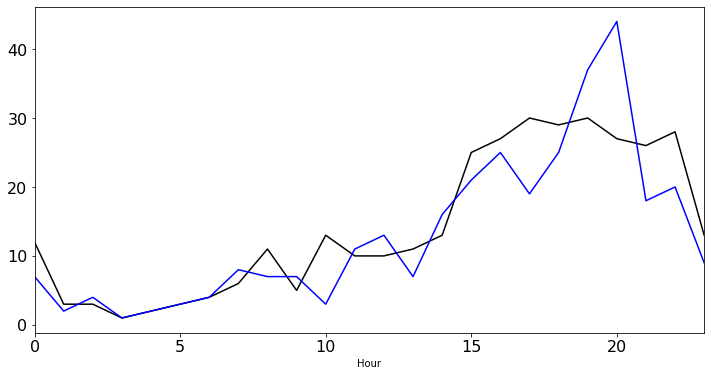

In [65]:
most_graph = most_h.Trips.sort_index().plot(kind='line', figsize=(12,6), color='black', fontsize=16)

mirror_graph =mostM_h.Trips.sort_index().plot(kind='line', figsize=(12,6), color='blue', fontsize=16)

Using line plot shows that there really are not very big change in direction of the route during the day. 